In [167]:
import numpy as np
import pandas as pd

In [168]:
data = pd.read_csv('../data/large_skill_injector_domain.csv')

In [169]:
data.head()

,average,date,highest,lowest,order_count,volume
0,797900000.0,2022-07-01,804300000,793000000.0,182,217
1,797700000.0,2022-07-02,805450000,790000000.0,110,139
2,809600000.0,2022-07-03,818750000,800500000.0,98,110
3,824200000.0,2022-07-04,825000000,819200000.0,103,127
4,829700000.0,2022-07-05,833500000,826500000.0,103,132


In [170]:
# Change the index to the date column since we are doing time series predictions
data = data.set_index('date')


<Axes: xlabel='date'>

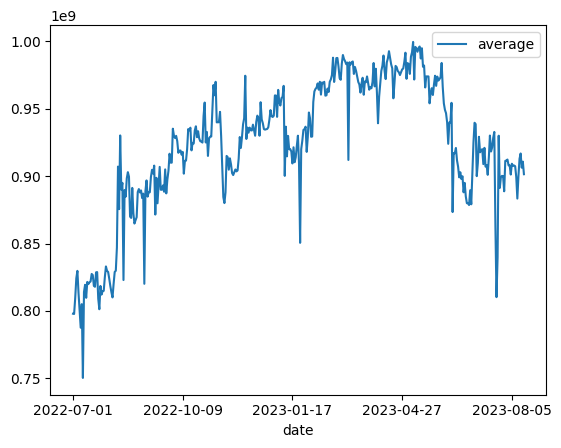

In [171]:
# Plot out each of our values to try and find a stable one to predict decided on average
data.plot.line(y="average", use_index=True)
# data.plot.line(y="lowest", use_index=True)
# data.plot.line(y="highest", use_index=True)

In [172]:
# Create our tomrrow column from our historic data
data["tomorrow"] = data["average"].shift(-1)

In [173]:
# Create our target column for our ML that just determines if the average will increase or decrease
data["target"] = (data["tomorrow"] > data["average"]).astype(int)
data.loc[data["tomorrow"] > data["average"], "movement"] = 1
data.loc[data["tomorrow"] < data["average"], "movement"] = -1

data = data.dropna()
data.isna().value_counts()

average  highest  lowest  order_count  volume  tomorrow  target  movement
False    False    False   False        False   False     False   False       403
Name: count, dtype: int64

In [174]:
# Default model
from sklearn.ensemble import RandomForestClassifier

In [175]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

predictors = ["average", "highest", "lowest", "order_count", "volume"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [176]:
from sklearn.metrics import precision_score

# Get our predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)


In [177]:
# Score our model
precision_score(test["target"], preds)

0.5694444444444444

<Axes: xlabel='date'>

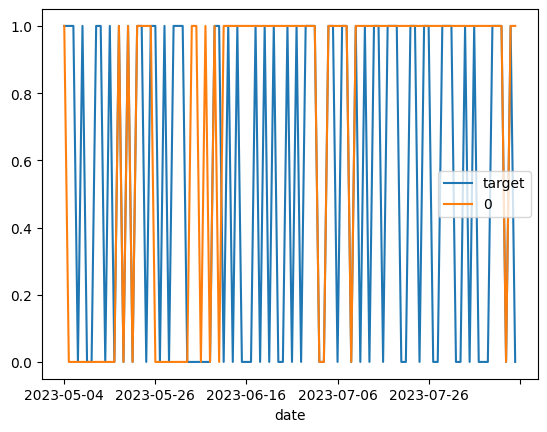

In [178]:
# Plot our predictions
combined = pd.concat([test["target"], preds], axis=1)
combined.plot()

In [179]:
# Start of initial backtest
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined
    

In [180]:
def backtest(data,model, predictors, start=100, step=2):
    all_predictions = []

    for i in range(start, data.shape[0], step):
      train = data.iloc[0:i].copy()
      test = data.iloc[i:(i+step)].copy()
      predictions = predict(train, test, predictors, model)
      all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [181]:
predictions = backtest(data, model, predictors)

In [182]:
predictions["predictions"].value_counts()

predictions
1    172
0    131
Name: count, dtype: int64

In [183]:
precision_score(predictions["target"], predictions["predictions"])

0.622093023255814

In [184]:
predictions["target"].value_counts() / predictions.shape[0]

target
1    0.537954
0    0.462046
Name: count, dtype: float64

In [197]:
# Adding horizons to the data to help with predictions
horizons = [2,7,14]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()

    ratio_column = f"close_ratio_{horizon}"
    data[ratio_column] = data['average'] / rolling_averages['average']

    trend_column = f"trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["movement"]

    new_predictors += [ratio_column, trend_column]

/var/folders/8j/cp_9m_3j4b5g771cdngzxwc00000gn/T/ipykernel_36701/2596634467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ratio_column] = data['average'] / rolling_averages['average']
/var/folders/8j/cp_9m_3j4b5g771cdngzxwc00000gn/T/ipykernel_36701/2596634467.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[trend_column] = data.shift(1).rolling(horizon).sum()["movement"]


In [198]:
# Start of model that predicts the probabilities
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [199]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds< .6] = 0
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined
    

In [200]:
data = data.dropna()
data

,average,highest,lowest,order_count,volume,tomorrow,target,movement,close_ratio_2,trend_2,close_ratio_7,trend_7,close_ratio_14,trend_14
date,,,,,,,,,,,,,,
2022-07-29,8.149000e+08,819900000,813900000.0,128,176,8.250000e+08,1,1.0,1.000123,2.0,1.000894,1.0,0.995401,2.0
2022-07-30,8.250000e+08,836200000,820000000.0,138,206,8.330000e+08,1,1.0,1.006159,2.0,1.013975,1.0,1.007405,2.0
2022-07-31,8.330000e+08,857000000,804500000.0,130,223,8.297000e+08,0,-1.0,1.004825,2.0,1.019512,3.0,1.016181,2.0
2022-08-01,8.297000e+08,832750000,757900000.0,158,192,8.289000e+08,0,-1.0,0.998015,0.0,1.010441,3.0,1.011952,0.0
2022-08-02,8.289000e+08,829300000,828200000.0,89,104,8.240000e+08,0,-1.0,0.999518,-2.0,1.007644,1.0,1.010774,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11,9.000000e+08,906150000,887700000.0,158,203,9.129000e+08,1,1.0,1.009339,0.0,0.997649,-1.0,0.996202,-2.0
2023-08-12,9.129000e+08,914900000,895000000.0,134,208,9.168000e+08,1,1.0,1.007116,2.0,1.011356,-1.0,1.009452,0.0
2023-08-13,9.168000e+08,918500000,911900000.0,92,134,9.062789e+08,0,-1.0,1.002131,2.0,1.014184,1.0,1.011523,2.0


In [201]:
predictions = backtest(data, model, new_predictors)

In [202]:
predictions["predictions"].value_counts()

predictions
0.0    167
1.0    108
Name: count, dtype: int64

In [203]:
precision_score(predictions["target"], predictions["predictions"])

0.6111111111111112